# ImpDAR ApRES Tutorial

This is an overview of the ApRES functions implemented in ImpDAR. ApRES (Autonomous phase-sensitive Radio Echo Sounder) is a radar system designed to measure vertical ice motion using phase offset (Nicholls et al., 2015). The Python functions in ImpDAR were rewritten from a series of MATLAB scripts (Brennan et al., 2013) (https://discovery.ucl.ac.uk/id/eprint/1425855/1/Brennan_IET-RSN.2013.0053.pdf). The main functionality includes: 
- loading the data files into an ImpDAR-style .mat file
- pulse compression and range conversion
- chirp stacking
- uncertainty
- phase coherence

We overview each of these below.

In [1]:
# First import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Import the impdar functions that will be needed
import impdar
from impdar.lib.ApresData.load_apres import load_apres
from impdar.lib.ApresData._ApresDataProcessing import apres_range,stacking,phase2range,phase_uncertainty,range_diff

# Plot the data inline instead of with qt5
%matplotlib inline

## Take a look at the data file

ApRES data files are binary, so we need to read them in with the load_apres function.

In [2]:
# Load an example file to look at the settings
fname = ['./data/DATA2019-01-01-0337.DAT']
apres_data = load_apres(fname)

print('### File Header ###: \n\n')
for arg in vars(apres_data.header):
    if arg != 'header_string':
        print(arg,': ', vars(apres_data.header)[arg])

print('\n\n\n\n\n\n ### File Data ###: \n\n')
for arg in vars(apres_data):
    print(arg,': ', vars(apres_data)[arg])

### File Header ###: 


fsysclk :  1000000000.0
fs :  40000.0
fn :  ./data/DATA2019-01-01-0337.DAT
file_format :  5
noDwellHigh :  1
noDwellLow :  0
f0 :  199999999.95343387
f_stop :  399999999.90686774
ramp_up_step :  5000.03807246685
ramp_down_step :  5000.03807246685
tstep_up :  2.5e-05
tstep_down :  2.5e-05
snum :  40000
nsteps_DDS :  40000
chirp_length :  1
chirp_grad :  1256646630.09049
nchirp_samples :  40000
ramp_dir :  up
n_attenuators :  1
attenuator1 :  [20]
attenuator2 :  [-4]
tx_ant :  [1]
rx_ant :  [1]
f1 :  400001522.8521079
bandwidth :  200001522.898674
fc :  300000761.4027709
er :  3.18
ci :  168231646.22761327
lambdac :  0.5607707308507499






 ### File Data ###: 


snum :  40000
cnum :  100
bnum :  1
data :  [[[0.09815216 1.24504089 1.23912811 ... 1.42715454 1.4263916  1.42673492]
  [1.43409729 1.26480103 1.27113342 ... 1.40258789 1.40041351 1.40285492]
  [1.41525269 1.2676239  1.28131866 ... 1.42040253 1.41937256 1.41994476]
  ...
  [1.42852783 1.23825073 1.234474

The raw volages measured at the receiver are not directly interpretable. However, we plot them below to make it clear exactly what is stored in the data file.

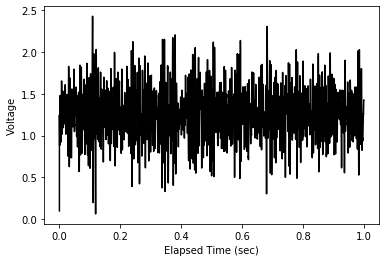

In [3]:
# plot the raw voltages
plt.figure()
plt.plot(apres_data.travel_time/1e6,apres_data.data[0][0],'k')
plt.ylabel('Voltage')
plt.xlabel('Elapsed Time (sec)');

## Pulse Compression and Range Conversion

Since this is an FMCW (frequency modulated continuous wave) radar system, the elapsed time in the above figure is not directly convertible to a depth below the surface. Instead, we need to do a pulse compression with the transmitted radar pulse. The code in the next cell are also embedded in the ImpDAR function apres_range(), but we display them here for clarity.

/Users/dlilien/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


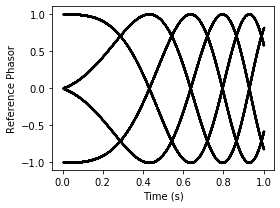

In [4]:
# Calculate phase for each range bin centre (measured at t=T/2), given that tau = n/(B*p)
t = apres_data.travel_time*1e-6    # Time
K = apres_data.header.chirp_grad   # FM sweep rate
B = apres_data.header.bandwidth    # bandwidth
p = 2  # pad factor for Fourier Transform
nf = int(np.floor(p*apres_data.snum/2))  # number of frequencies to recover
tau = np.arange(nf)/(B*p)  # round-trip delay between antennas
# Brennan et al., (2014) eq 17
ϕ_r = 2.*np.pi*apres_data.header.fc*tau - (K*tau**2)/2.  # reference phasor

# --------------------------------------

# Plot the reference phasor
plt.figure(figsize=(4,3))
plt.plot(t,np.exp(-1j*ϕ_r),'k.',ms=1)
plt.ylabel('Reference Phasor')
plt.xlabel('Time (s)');
plt.tight_layout()

The ImpDAR function, apres_range, uses the reference phasor shown above to convert from the elapsed time to a range measurement. As explaned by Brennan et al. (2013) section 3, the FFT-processed waveform is weighted by the phase conjugate of the reference phasor to do the pulse compression. After executing this function, the data are more interpretable.

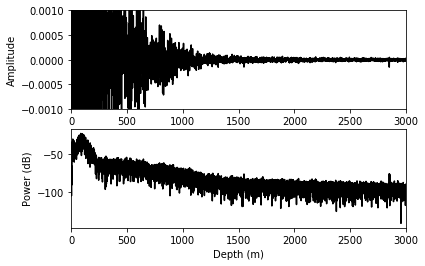

In [5]:
# Reload the data file
apres_data = load_apres(fname)
# pulse compression with the reference phasor
apres_range(apres_data,p)

# Plot one chirp from the data file
plt.figure()
# Amplitude
plt.subplot(211)
plt.plot(apres_data.Rcoarse,apres_data.data[0][0],'k')
plt.xlim(0,3000)
plt.ylim(-.001,.001)
plt.ylabel('Amplitude')
plt.xlabel('Depth (m)')
# Power
plt.subplot(212)
plt.plot(apres_data.Rcoarse,10.*np.log10(apres_data.data[0][0]**2.),'k')
plt.xlim(0,3000)
plt.ylabel('Power (dB)');
plt.xlabel('Depth (m)');

## Stacking 

As with any system, we want to stack many ApRES chirps together in order to increase the signal-to-noise ratio. The ImpDAR function, stacking(), does this for us by averaging the signal over the given number of chirps. 

The ApRES system writes a new file for every 'burst' (set of 100 chirps). However, the load function can handle multiple files if desired. By default, the stacking function will stack across bursts. When stacking each burst individually, change the number of chirps input to the stacking() function to self.cnum.

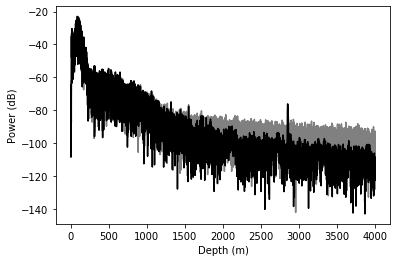

In [6]:
# Reload the data file
apres_data = load_apres(fname)
# Pulse compression
apres_range(apres_data,2,max_range=4000)

# Plot the first chirp from the unstacked data
plt.figure()
plt.plot(apres_data.Rcoarse,10.*np.log10(apres_data.data[0][0]**2.),'grey')

# Reload and stack before pulse compression
apres_data = load_apres(fname)
stacking(apres_data)
apres_range(apres_data,2,max_range=4000)

# Plot the stacked chirp
plt.plot(apres_data.Rcoarse,10.*np.log10(apres_data.data[0][0]**2.),'k')
plt.xlabel('Depth (m)');
plt.ylabel('Power (dB)');

## Uncertainty

ImpDAR has two methods for calculating uncertainty in ApRES data. The first is a calculation of the phase uncertainty for a single acquisition using a 'noise phasor' as done by Kingslake et al. (2014). The second is the coherence uncertainty between two acquisitions which we will show later on. 

The 'noise phasor' has random phase and amplitude equal to the median amplitude of the measured (or stacked) chirp. This can be calculated with the phase_uncertainty() function in ImpDAR.

/Users/dlilien/work/sw/impdar/impdar/impdar/lib/ApresData/_ApresDataProcessing.py:164: RuntimeWarning: invalid value encountered in arcsin
  p_uncertainty = np.abs(np.arcsin(noise_orth/np.abs(meas_phasor)))


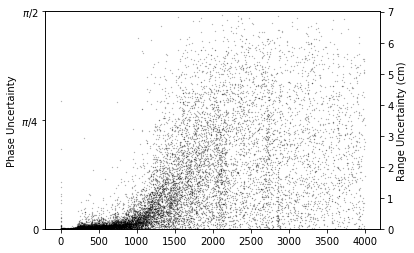

In [7]:
# Reload the data file
apres_data = load_apres(fname)
# Pulse compression
stacking(apres_data)
apres_range(apres_data,2,max_range=4000)
# Calculate the uncertainty
ϕ_unc,r_unc = phase_uncertainty(apres_data)

plt.figure()
# phase axis
ax1 = plt.subplot(111)
plt.plot(apres_data.Rcoarse,ϕ_unc[0][0],'k.',ms=0.5,alpha=0.5)
plt.ylim(0,np.pi/2.)
plt.yticks([0,np.pi/4.,np.pi/2.],labels=['0','$\pi$/4','$\pi$/2'])
plt.ylabel('Phase Uncertainty');
# twin axis for range
axt = plt.twinx(ax1)
plt.ylim(0,100.*phase2range(np.pi/2.,apres_data.header.lambdac));
plt.ylabel('Range Uncertainty (cm)');

## Phase Coherence

The coherence between two acquisitions is calculated using a correlation coefficient on samples within a moving window using the function, range_diff(). The output from this function gives: the depths at the center of the window for each step, the coherence resulting from the correlation at each step, the range difference between acquisitions, and the uncertainty.

This coherence value can be used to calculate the range difference (one of the outputs as stated above), but can also be used for polarimetric coherence (e.g. Jordan et al., 2020).

The default uncertainty calculation in this case is to use the Cramer Rao bound (e.g. Jordan et al., 2020). Another option though, is to use the 'noise-phasor' uncertainty as above calculated in each acquisition and added together for the total uncertainty. This is an option in the range_diff() function.

/Users/dlilien/work/sw/impdar/impdar/impdar/lib/ApresData/_ApresDataProcessing.py:289: RuntimeWarning: Mean of empty slice
  r_diff_unc = np.array([np.nanmean(r_uncertainty[i-win//2:i+win//2]) for i in idxs])


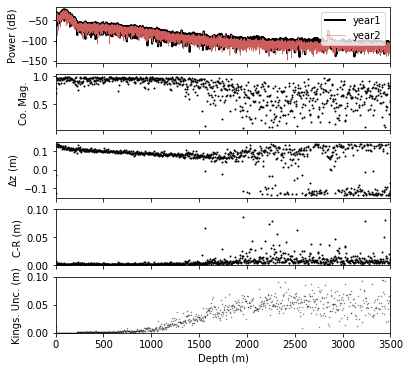

In [8]:
# Load the data from year 1
fname1 = ['./data/DATA2019-01-01-0337.DAT']
apres_data1 = load_apres(fname1)
stacking(apres_data1)
apres_range(apres_data1,2)
ϕ1_unc,r1_unc = phase_uncertainty(apres_data1)
acq1 = apres_data1.data[0][0]
# Load the data from year 2
fname2 = ['./data/DATA2019-12-21-0025.DAT']
apres_data2 = load_apres(fname2)
stacking(apres_data2)
apres_range(apres_data2,2)
ϕ2_unc,r2_unc = phase_uncertainty(apres_data2)
acq2 = apres_data2.data[0][0]

# Do the phase-coherence calculation 
# over a small moving window from top to bottom of profile
win = 20    # number of samples in the window
step = 20   # window step (number of samples)
ds,phase_diff,r_diff,r_diff_err = range_diff(apres_data1,acq1,acq2,win,step)
amp = abs(phase_diff)  # the magnitude of phase coherence

# ---------------------------------------------------------

# Plot a figure
plt.figure(figsize=(6,6))
# Plot the stacked profile from each acquisition
plt.subplot(511)
plt.tick_params(labelbottom=False)
plt.xlim(0,3500)
plt.plot(apres_data1.Rcoarse,10.*np.log10(acq1**2.),'k',lw=2,label='year1')
plt.plot(apres_data2.Rcoarse,10.*np.log10(acq2**2.),'indianred',lw=.5,label='year2')
plt.ylabel('Power (dB)')
plt.legend()
# Plot the magnitude of coherence between seasons
ax2 = plt.subplot(512)
plt.tick_params(labelbottom=False)
plt.xlim(0,3500)
plt.plot(ds,amp,'k.',ms=2)
plt.ylabel('Co. Mag.')
# Plot the phase offset (converted to range)
ax3 = plt.subplot(513)
plt.tick_params(labelbottom=False)
plt.xlim(0,3500)
plt.plot(ds,r_diff,'.',color='k',label='%s'%win,ms=2,zorder=1)
plt.ylabel('$\Delta$z (m)')
# Plot the uncertainty calculated from the Cramer-Rao Bound (Jordan et al., 2020)
plt.subplot(514)
plt.tick_params(labelbottom=False)
plt.xlim(0,3500)
plt.ylim(0,.1)
plt.plot(ds,r_diff_err,'k.',ms=2)
plt.ylabel('C-R (m)');
# Redo the calculation for 'noise-phasor' uncertianty and plot
ds,phase_diff,r_diff,r_diff_err = range_diff(apres_data1,acq1,acq2,win,step,
                                             r_uncertainty=r1_unc[0][0]+r2_unc[0][0],
                                            uncertainty='noise_phasor')
plt.subplot(515)
plt.xlim(0,3500)
plt.ylim(0,.1)
plt.plot(ds,r_diff_err,'k.',ms=1,alpha=0.5)
plt.ylabel('Kings. Unc. (m)');
plt.xlabel('Depth (m)');